In [2]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import timm

In [6]:
base_path = "/kaggle/input"

for root, dirs, files in os.walk(base_path):
    print(root)
    break

/kaggle/input


In [8]:
import os

for root, dirs, files in os.walk("/kaggle/input"):
    print(root)


/kaggle/input
/kaggle/input/datasets
/kaggle/input/datasets/kelkalot
/kaggle/input/datasets/tansyab1
/kaggle/input/datasets/tansyab1/hyperkvasir
/kaggle/input/datasets/tansyab1/hyperkvasir/labeled-images
/kaggle/input/datasets/tansyab1/hyperkvasir/labeled-images/upper-gi-tract
/kaggle/input/datasets/tansyab1/hyperkvasir/labeled-images/upper-gi-tract/pathological-findings
/kaggle/input/datasets/tansyab1/hyperkvasir/labeled-images/upper-gi-tract/pathological-findings/barretts
/kaggle/input/datasets/tansyab1/hyperkvasir/labeled-images/upper-gi-tract/pathological-findings/esophagitis-a
/kaggle/input/datasets/tansyab1/hyperkvasir/labeled-images/upper-gi-tract/pathological-findings/esophagitis-b-d
/kaggle/input/datasets/tansyab1/hyperkvasir/labeled-images/upper-gi-tract/pathological-findings/barretts-short-segment
/kaggle/input/datasets/tansyab1/hyperkvasir/labeled-images/upper-gi-tract/anatomical-landmarks
/kaggle/input/datasets/tansyab1/hyperkvasir/labeled-images/upper-gi-tract/anatomical-

In [10]:
import os

data_dir = "/kaggle/input/datasets/tansyab1/hyperkvasir/labeled-images"

image_paths = []
labels = []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".jpg"):
            image_paths.append(os.path.join(root,file))
            labels.append(root.split("/")[-1])

print("Total images:", len(image_paths))
print("Sample labels:", list(set(labels))[:10])


Total images: 10662
Sample labels: ['dyed-lifted-polyps', 'ulcerative-colitis-grade-2-3', 'esophagitis-b-d', 'impacted-stool', 'z-line', 'retroflex-rectum', 'barretts-short-segment', 'bbps-0-1', 'dyed-resection-margins', 'ulcerative-colitis-grade-3']


In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

print("Total classes:", len(le.classes_))
print(le.classes_)


Total classes: 23
['barretts' 'barretts-short-segment' 'bbps-0-1' 'bbps-2-3' 'cecum'
 'dyed-lifted-polyps' 'dyed-resection-margins' 'esophagitis-a'
 'esophagitis-b-d' 'hemorrhoids' 'ileum' 'impacted-stool' 'polyps'
 'pylorus' 'retroflex-rectum' 'retroflex-stomach'
 'ulcerative-colitis-grade-0-1' 'ulcerative-colitis-grade-1'
 'ulcerative-colitis-grade-1-2' 'ulcerative-colitis-grade-2'
 'ulcerative-colitis-grade-2-3' 'ulcerative-colitis-grade-3' 'z-line']


In [12]:

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image

class GI_Dataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)
            
        return img, label

transform = transforms.Compose([
    transforms.Resize((260,260)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

dataset = GI_Dataset(image_paths, encoded_labels, transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

print("Dataset ready:", len(dataset))


Dataset ready: 10662


In [15]:
import timm
import torch.nn as nn

model = timm.create_model("efficientnet_b2", pretrained=True)

model.classifier = nn.Linear(model.classifier.in_features, 23)

model = model.cuda()

print("Model loaded")


model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

Model loaded


In [16]:
import torch.optim as optim

device = "cuda"

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0003)

print("Training setup ready")


Training setup ready


In [17]:
# freeze backbone
for param in model.parameters():
    param.requires_grad = False

# unfreeze classifier
for param in model.classifier.parameters():
    param.requires_grad = True

model.train()

EPOCHS = 5

for epoch in range(EPOCHS):
    total_loss = 0
    
    for imgs, labels_batch in loader:
        imgs = imgs.to(device)
        labels_batch = labels_batch.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss:", total_loss/len(loader))


Epoch 1 Loss: 1.6792974623734365
Epoch 2 Loss: 0.9238372041793641
Epoch 3 Loss: 0.731743551032272
Epoch 4 Loss: 0.6492647895377553
Epoch 5 Loss: 0.5928111086170117


In [18]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels_batch in loader:
        imgs = imgs.to(device)
        labels_batch = labels_batch.to(device)

        outputs = model(imgs)
        preds = torch.argmax(outputs,1)

        correct += (preds == labels_batch).sum().item()
        total += labels_batch.size(0)

print("Accuracy:", correct/total)


Accuracy: 0.8485274807728381


In [20]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def predict_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img_t = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(img_t)
        prob = F.softmax(out, dim=1)
        pred = prob.argmax(1).item()
        confidence = prob[0][pred].item()

    plt.imshow(img)
    plt.title(f"{le.classes_[pred]}  ({confidence:.2f})")
    plt.axis("off")


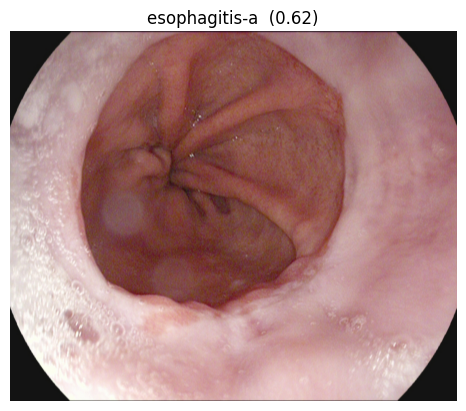

In [21]:
predict_image(image_paths[100])


In [22]:
!pip install grad-cam -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.6 MB/s eta 0:00:00:00:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [26]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
import numpy as np

target_layer = model.blocks[-1]

cam = GradCAM(model=model, target_layers=[target_layer])


In [29]:
def show_gradcam(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img,(224,224))

    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.0

    tensor = torch.tensor(rgb).permute(2,0,1).unsqueeze(0).float().to(device)

    grayscale_cam = cam(input_tensor=tensor)[0]

    vis = show_cam_on_image(rgb, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(6,6))
    plt.imshow(vis)
    plt.axis("off")


In [31]:
for param in model.parameters():
    param.requires_grad = True


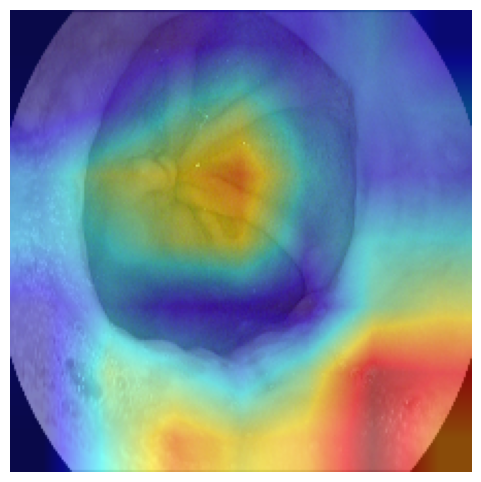

In [32]:
show_gradcam(image_paths[100])


In [33]:
torch.save(model.state_dict(), "gi_model.pth")
